# Structure of the notebook 

This notebook utilizes the cleaned dataset of the taxi trip record data. 

This notebook sets the basis for **Chapter 3.4 Data Preparation:**
<ul>
    <li>Data Wrangling and Feature Engineering for Temporal Forecasting (Chapter 3.4.1)</li>
    <li>Data Wrangling and External Data Integration for Spatiotemporal Forecasting (Chapter 3.4.2)</li>
</ul>

# Libraries required to run this notebook

In [2]:
import pandas as pd
! pip install -q xlrd
! pip install -q openpyxl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statistics
import matplotlib.dates as mdates
import warnings
warnings.filterwarnings("ignore")
! pip install -q geopandas
import geopandas as gpd

# Data reading

In [27]:
# Read the data

taxi_data_outl = pd.read_parquet("gs://taxi_data_outl/taxi_data_outl.parquet", columns = ['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'passenger_count', 'trip_distance', 'PULocationID', 'DOLocationID', 'total_amount'])

# Data wrangling and feature engineering for temporal forecasting

In the temporal modeling of demand patterns, the number of trips for a given hour is predicted.To achieve this, the initial table is transformed. Information on the given data is leveraged to create adequate input features. It has to be noted that it was decided to limit the analysis to the trips that started in Manhattan.

## Data wrangling

In [28]:
# PULocationIDs located in Manhattan

valid_locs = [4, 12, 13, 24, 41, 42, 43, 45, 48, 50, 68, 74, 75, 79, 87, 88, 90, 100, 107, 113, 114, 116, 120, 125, 127, 128, 137, 140, 141, 142, 143, 144, 148, 151, 152, 153, 158, 161, 162, 163, 164, 166, 170, 186, 194, 202, 209, 211, 224, 229, 230, 231, 232, 233, 234, 236, 237, 238, 239, 243, 244, 246, 249, 261, 262, 263]

# Create a new dataframe which only contains trips that started in Manhattan

taxi_data_manh = taxi_data_outl[taxi_data_outl['PULocationID'].isin(valid_locs)]

In [29]:
# Create a new dataframe which displays the number of trips for each hour 
# Calculate the average trip distance, and total amount for each hour

hourly_pickups = taxi_data_manh.groupby(pd.Grouper(freq='H', key='tpep_pickup_datetime')).agg({
    'trip_distance': 'mean',
    'total_amount': 'mean'
})

hourly_pickups['PU_count'] = taxi_data_manh.groupby(pd.Grouper(freq='H', key='tpep_pickup_datetime')).size().values
hourly_pickups = hourly_pickups.reindex()

In [30]:
# Reset the datetime index
hourly_data_wo_index = hourly_pickups.reset_index()

# Re-arrange the column order to get a better overview
pu_count = hourly_data_wo_index.pop('PU_count')
hourly_data_wo_index.insert(1, 'PU_count', pu_count)
print(hourly_data_wo_index)

     tpep_pickup_datetime  PU_count  trip_distance  total_amount
0     2022-01-01 00:00:00      3507       2.757311     18.051933
1     2022-01-01 01:00:00      4051       2.851516     18.022978
2     2022-01-01 02:00:00      3100       3.046068     18.365532
3     2022-01-01 03:00:00      2211       3.256635     18.679724
4     2022-01-01 04:00:00      1321       3.652210     19.909424
...                   ...       ...            ...           ...
4339  2022-06-30 19:00:00      6095       2.446198     17.807930
4340  2022-06-30 20:00:00      4972       2.489913     17.327742
4341  2022-06-30 21:00:00      5177       2.577813     17.464085
4342  2022-06-30 22:00:00      4839       2.819064     18.180460
4343  2022-06-30 23:00:00      2979       2.686022     17.363106

[4344 rows x 4 columns]


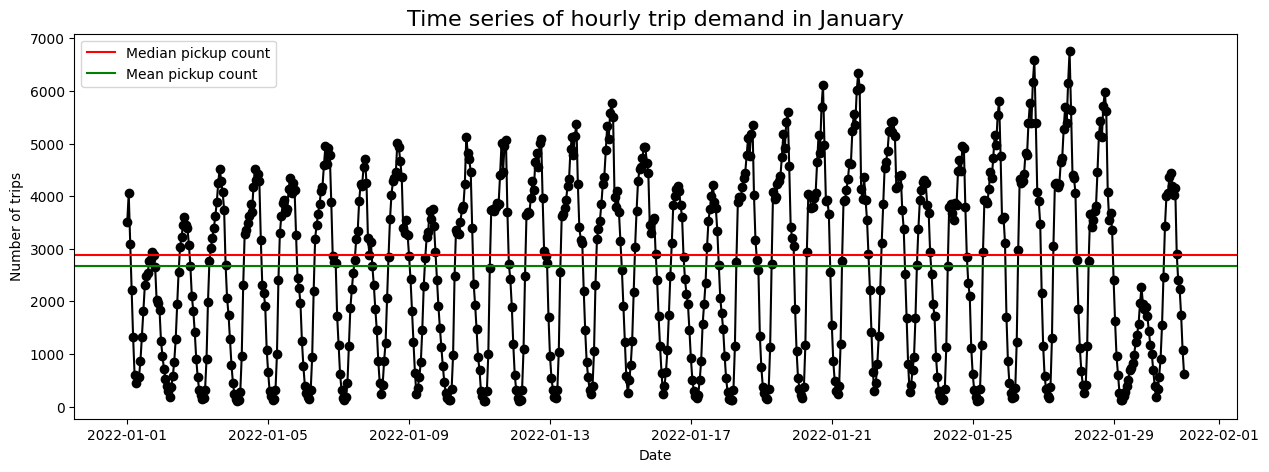

In [31]:
# Use an exemplary time interval (January) to get an overview of the hourly demand time series

# Filter the data for January
filtered_data = hourly_data_wo_index[(hourly_data_wo_index['tpep_pickup_datetime'] >= '2022-01-01') & (hourly_data_wo_index['tpep_pickup_datetime'] <= '2022-01-31')]

# Create the time series plot

plt.figure(figsize=(15,5), dpi=100)
x = filtered_data['tpep_pickup_datetime']
y = filtered_data['PU_count']
plt.plot_date(x, y, color='black', linestyle='solid')
plt.xlabel("Date")
plt.axhline(y=np.median(y), color='red', label='Median pickup count')
plt.axhline(y=np.mean(y), color='green', label='Mean pickup count')
plt.ylabel("Number of trips")
plt.legend(fontsize=10)
plt.title("Time series of hourly trip demand in January", fontsize=16)
plt.show()

## Feature engineering

Multiple feature engineering techniques were emplyoed to derive useful information from the dataset.

### Datetime features

In [32]:
# Create new columns, representing the month, day of the month, day of the week, and hour of the pickup time extracted from the 'tpep_pickup_datetime' column

hourly_data_wo_index.insert(loc=2, column='PU_month', value=hourly_data_wo_index['tpep_pickup_datetime'].dt.month)
hourly_data_wo_index.insert(loc=3, column='PU_day_of_month', value=hourly_data_wo_index['tpep_pickup_datetime'].dt.day)
hourly_data_wo_index.insert(loc=4, column='PU_day_of_week', value=hourly_data_wo_index['tpep_pickup_datetime'].dt.weekday)
hourly_data_wo_index.insert(loc=5, column='PU_hour', value=hourly_data_wo_index['tpep_pickup_datetime'].dt.hour)

### Autoregressive features

In [35]:
manhattan_df = hourly_data_wo_index.copy()

# Add lagged features of the 'PU_count' column to the DataFrame with different time intervals (1 hour, 2 hours, 1 day, and 2 days)

manhattan_df.insert(8, 'lag_1h', manhattan_df['PU_count'].shift(1))
manhattan_df.insert(9, 'lag_2h', manhattan_df['PU_count'].shift(2))
manhattan_df.insert(10, 'lag_1d', manhattan_df['PU_count'].shift(24))
manhattan_df.insert(11, 'lag_2d', manhattan_df['PU_count'].shift(48))

# Filling the missing values in the lagged columns with 0 (to prevent NaNs at the beginning of the lagged columns)
manhattan_df['lag_1h'] = manhattan_df['lag_1h'].fillna(0)
manhattan_df['lag_2h'] = manhattan_df['lag_2h'].fillna(0)
manhattan_df['lag_1d'] = manhattan_df['lag_1d'].fillna(0)
manhattan_df['lag_2d'] = manhattan_df['lag_2d'].fillna(0)

### Rolling statistics features

In [36]:
# Calculate the exponentially weighted moving averages (EWMA) of the 'PU_count' column  with different window sizes:
# 3 hours, 6 hours, 12 hours, and 24 hours
manhattan_df['ewma_3h'] = manhattan_df['PU_count'].ewm(span=3).mean()
manhattan_df['ewma_6h'] = manhattan_df['PU_count'].ewm(span=6).mean()
manhattan_df['ewma_12h'] = manhattan_df['PU_count'].ewm(span=12).mean()
manhattan_df['ewma_24h'] = manhattan_df['PU_count'].ewm(span=24).mean()
manhattan_df.head()

,tpep_pickup_datetime,PU_count,PU_month,PU_day_of_month,PU_day_of_week,PU_hour,trip_distance,total_amount,lag_1h,lag_2h,lag_1d,lag_2d,ewma_3h,ewma_6h,ewma_12h,ewma_24h
0,2022-01-01 00:00:00,3507,1,1,5,0,2.757311,18.051933,0.0,0.0,0.0,0.0,3507.000000,3507.000000,3507.000000,3507.000000
1,2022-01-01 01:00:00,4051,1,1,5,1,2.851516,18.022978,3507.0,0.0,0.0,0.0,3869.666667,3824.333333,3801.666667,3790.333333
2,2022-01-01 02:00:00,3100,1,1,5,2,3.046068,18.365532,4051.0,3507.0,0.0,0.0,3429.857143,3498.715596,3527.806005,3540.791209
3,2022-01-01 03:00:00,2211,1,1,5,3,3.256635,18.679724,3100.0,4051.0,0.0,0.0,2779.800000,3001.320946,3112.141810,3165.683113
4,2022-01-01 04:00:00,1321,1,1,5,4,3.652210,19.909424,2211.0,3100.0,0.0,0.0,2026.870968,2411.575208,2625.494982,2732.809394


In [37]:
# Export the final dataframe

manhattan_df.to_csv('gs://final_prep_data/global_temporal_features.csv', index=False)

## Correlation analysis of predictor variables

As the autoregressive and rolling statistics features were all created from the dependent variable **PU_count**, relationships among the deployed features are likely. This will be investigated more closely in the following.

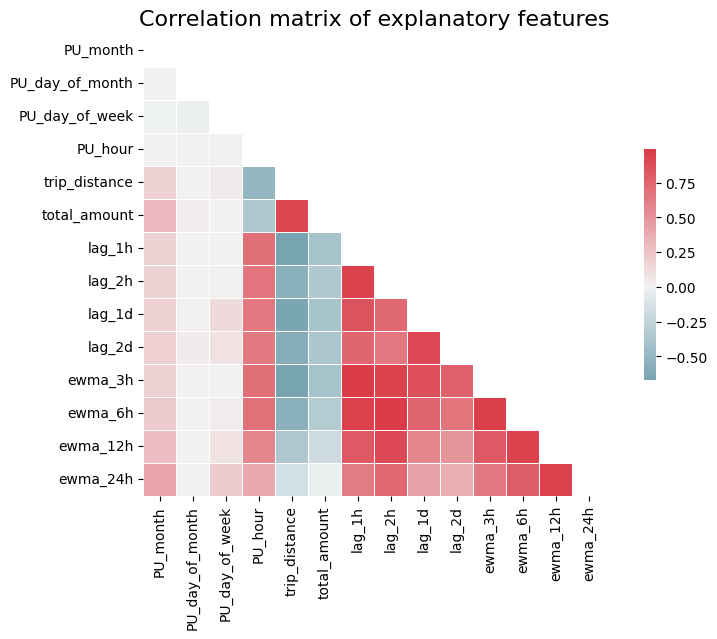

In [39]:
# Visualization of the correlation matrix using a heatmap

# Compute the correlation matrix
corr_matrix = manhattan_df.corr()

# Exclude dependent variable 'PU_count' from the correlation matrix
corr_matrix_excluding_target = corr_matrix.drop('PU_count', axis=0).drop('PU_count', axis=1)


mask = np.triu(np.ones_like(corr_matrix_excluding_target, dtype=bool))
fig, ax = plt.subplots(figsize=(10, 6))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr_matrix_excluding_target, mask=mask, cmap=cmap, annot=False, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Correlation matrix of explanatory features', fontsize=16)
# .savefig('multicoll_temporal.png')
plt.show()

In [40]:
# Get all feature pairs with correlation greater than 0.7

high_corr_pairs = [(corr_matrix_excluding_target.columns[i], corr_matrix_excluding_target.columns[j]) for i in range(len(corr_matrix_excluding_target.columns))
                  for j in range(i+1, len(corr_matrix_excluding_target.columns)) if abs(corr_matrix_excluding_target.iloc[i,j]) > 0.7]

# Print the high correlated feature pairs
for pair in high_corr_pairs:
    print(f"{pair[0]} and {pair[1]} have an autocorrelation > 0.7")

PU_hour and ewma_3h have an autocorrelation > 0.7
trip_distance and total_amount have an autocorrelation > 0.7
lag_1h and lag_2h have an autocorrelation > 0.7
lag_1h and lag_1d have an autocorrelation > 0.7
lag_1h and lag_2d have an autocorrelation > 0.7
lag_1h and ewma_3h have an autocorrelation > 0.7
lag_1h and ewma_6h have an autocorrelation > 0.7
lag_1h and ewma_12h have an autocorrelation > 0.7
lag_2h and lag_1d have an autocorrelation > 0.7
lag_2h and ewma_3h have an autocorrelation > 0.7
lag_2h and ewma_6h have an autocorrelation > 0.7
lag_2h and ewma_12h have an autocorrelation > 0.7
lag_2h and ewma_24h have an autocorrelation > 0.7
lag_1d and lag_2d have an autocorrelation > 0.7
lag_1d and ewma_3h have an autocorrelation > 0.7
lag_1d and ewma_6h have an autocorrelation > 0.7
lag_2d and ewma_3h have an autocorrelation > 0.7
ewma_3h and ewma_6h have an autocorrelation > 0.7
ewma_3h and ewma_12h have an autocorrelation > 0.7
ewma_6h and ewma_12h have an autocorrelation > 0.7
ewma

# Data wrangling and external data integreation for spatiotemporal forecasting

In spatiotemporal demand modeling, the code transforms the initial table to predict the number of trips at each hour for each location. The process involves similar steps to temporal processing, including feature engineering and incorporating additional external data

## Data wrangling

In [42]:
# Drop columns that are not required for subsequent analysis
taxi_data_outl.drop(['passenger_count', 'trip_distance', 'DOLocationID', 'total_amount', 'tpep_dropoff_datetime'], axis = 1, inplace = True)

# Limit the data to the pickups in Manhattan
valid_locs = [4, 12, 13, 24, 41, 42, 43, 45, 48, 50, 68, 74, 75, 79, 87, 88, 90, 100, 107, 113, 114, 116, 120, 125, 127, 128, 137, 140, 141, 142, 143, 144, 148, 151, 152, 153, 158, 161, 162, 163, 164, 166, 170, 186, 194, 202, 209, 211, 224, 229, 230, 231, 232, 233, 234, 236, 237, 238, 239, 243, 244, 246, 249, 261, 262, 263]
taxi_data_manhattan = taxi_data_outl[taxi_data_outl['PULocationID'].isin(valid_locs)]

# Setting the tpep_pickup_datetime column as the index of the dataframe
taxi_data_manhattan = taxi_data_manhattan.set_index('tpep_pickup_datetime')

# Group by PULocationID and resample hourly 
hourly_pickups = taxi_data_manhattan.groupby(['PULocationID', pd.Grouper(freq = 'H')]).size().reset_index(name = 'PU_count_per_hour')

# Create a new DataFrame with all possible combinations of PULocationID and hourly time intervals
hourly_range = pd.date_range(start='2022-01-01', end='2022-06-30 23:00:00', freq='H')
idx = pd.MultiIndex.from_product([hourly_pickups['PULocationID'].unique(), hourly_range], names=['PULocationID', 'tpep_pickup_datetime'])
all_hourly_pickups = pd.DataFrame({'PU_count_per_hour': np.nan}, index=idx)

# Merge with the hourly_pickups DataFrame to get the count of pickups per hour
merged_hourly_pickups = pd.merge(all_hourly_pickups, hourly_pickups, how='outer', left_index=True, right_on=['PULocationID', 'tpep_pickup_datetime'])

# Fill NaN values with 0
merged_hourly_pickups = merged_hourly_pickups.fillna(0)

# Drop unnecessary columns
merged_hourly_pickups.drop('PU_count_per_hour_x', axis = 1, inplace = True)
hourly_pickups = merged_hourly_pickups.rename(columns = {'PU_count_per_hour_y': 'PU_count'})

# Rename dataframe
manhattan_df = hourly_pickups.rename(columns={'hourly_pickups': 'manhattan_df'})

## Feature engineering

### Datetime features

In [43]:
manhattan_df.insert(loc=3, column='PU_month', value=manhattan_df['tpep_pickup_datetime'].dt.month)
manhattan_df.insert(loc=4, column='PU_day_of_month', value=manhattan_df['tpep_pickup_datetime'].dt.day)
manhattan_df.insert(loc=5, column='PU_day_of_week', value=manhattan_df['tpep_pickup_datetime'].dt.weekday)
manhattan_df.insert(loc=6, column='PU_hour', value=manhattan_df['tpep_pickup_datetime'].dt.hour)

### Autoregressive features

In [44]:
manhattan_df = manhattan_df.copy()

manhattan_df.insert(3, 'lag_1h', manhattan_df.groupby(['PULocationID'])['PU_count'].shift(1))
manhattan_df.insert(4, 'lag_2h', manhattan_df.groupby(['PULocationID'])['PU_count'].shift(2))
manhattan_df.insert(5, 'lag_1d', manhattan_df.groupby(['PULocationID'])['PU_count'].shift(24))
manhattan_df.insert(6, 'lag_2d', manhattan_df.groupby(['PULocationID'])['PU_count'].shift(48))

manhattan_df['lag_1h'] = manhattan_df['lag_1h'].fillna(0)
manhattan_df['lag_2h'] = manhattan_df['lag_2h'].fillna(0)
manhattan_df['lag_1d'] = manhattan_df['lag_1d'].fillna(0)
manhattan_df['lag_2d'] = manhattan_df['lag_2d'].fillna(0)

### Rolling statistics features

In [45]:
manhattan_df['ewma_3h'] = manhattan_df['PU_count'].ewm(span=3).mean()
manhattan_df['ewma_6h'] = manhattan_df['PU_count'].ewm(span=6).mean()
manhattan_df['ewma_12h'] = manhattan_df['PU_count'].ewm(span=12).mean()
manhattan_df['ewma_24h'] = manhattan_df['PU_count'].ewm(span=24).mean()

### Weather data

Weather data was retrieved from the [NASA Data access viewer](https://power.larc.nasa.gov/data-access-viewer/). The selected attributes are: 

<ul>
    <li>T2M: The average air temperature at 2 meters above the surface of the earth</li>
    <li>T2MDEW: The dew/frost point temperature at 2 meters above the surface of the earth</li>
    <li>PRECTOTCORR: The bias corrected average of total precipitation at the surface of the earth in water mass (includes water content in snow)</li>
</ul>

In [50]:
# Read the dataframe

weather = pd.read_csv("gs://taxi_data_outl/pre-processed/Meteorological data_csv_archive.csv")

# Combine the YEAR, MO, DY, and HR columns into a single column of datetime format
weather["datetime"] = pd.to_datetime(weather[["YEAR", "MO", "DY", "HR"]].rename(columns={"YEAR": "year", "MO": "month", "DY": "day", "HR": "hour"}))

# Drop the YEAR, MO, DY, and HR columns
weather = weather.drop(columns=["YEAR", "MO", "DY", "HR"])

# To improve readability, the columns are renamed
weather = weather.rename(columns={"T2M": "temp", "PRECTOTCORR":"precip", "T2MDEW": "frost"})

In [51]:
# Convert the column datetime to datetime for subsequent merge
weather['datetime'] = pd.to_datetime(weather['datetime'])

# Join the weather data and pre-processed taxi-trip record data
manhattan_time_weather = pd.merge(manhattan_df, weather, how = 'left', left_on = 'tpep_pickup_datetime', right_on = 'datetime')

# Drop unneccessary column
manhattan_time_weather = manhattan_time_weather.drop(['datetime'], axis = 1)

In [52]:
# Fill missing values using forward fill
manhattan_time_weather[['precip', 'temp', 'frost']] = manhattan_time_weather[['precip', 'temp', 'frost']].ffill()

###  Socioeconomic and demographic data

Socioeconomic and demographic data was retrieved from the [American Community Survey](https://www.nyc.gov/site/planning/planning-level/nyc-population/american-community-survey.page) published by NYC's Department of City Planning. This survey examines the city's detailed demographic, socioeconomic and housing characteristics by Neighborhood Tabulation Area (NTA).The selected socioeconomic data includes:

<ul>
    <li>CvEm16pl1P - Employed population 16 years and over (in %)</li>
    <li>MdHHIncE - Median household income (estimates in dollars)</li>
    <li>HHI200plP - Houshold income $200,000 and more (in %)</li>
    <li>PopPvU1E - Income in the past 12 months below the poverty level / Population for whom poverty status is determined (estimates)</li>
</ul>

In [7]:
# Define the relevant columns
columns_to_keep_econ = ["GeoID", "Borough", "MdHHIncE", "HHI200plP", "PopPvU1E", "CvEm16pl1P"]

# Read the dataframe with the relevant columns only
econ_data = pd.read_excel("gs://taxi_data_outl/pre-processed/econ_20162020_pre_processed.xlsx", usecols = columns_to_keep_econ)

# Rename the columns
econ_data.rename(columns={"CvEm16pl1P": "employment_%","HHI200plP": "income_high_%", "MdHHIncE": "income_med_e", "PopPvU1E":"poverty_lev_e"}, inplace = True)

# Keep only socioeconomic data for Manhattan
econ_manh = econ_data[econ_data['Borough'] == 'Manhattan']

# Missing values are replaced with the median of each column

# Calculation of the median of each column
median_values = econ_manh.median()
# replacement of NaN values with median values
econ_manh_fillna = econ_manh.fillna(median_values)
print(econ_manh_fillna.sample(7))

      GeoID    Borough  employment_%  income_high_%  income_med_e  \
103  MN0602  Manhattan          71.9          32.50      138411.0   
108  MN0703  Manhattan          59.3          24.00       89580.0   
97   MN0303  Manhattan          59.4          16.60       64909.0   
90   MN0101  Manhattan          78.3          44.90      183075.0   
244  MN1292  Manhattan          65.1          28.05      114269.0   
120  MN1202  Manhattan          60.1           6.80       64875.0   
106  MN0701  Manhattan          65.1          36.30      141216.0   

     poverty_lev_e  
103          23919  
108          50556  
97           64059  
90           46243  
244              0  
120          78559  
106          62571  


The selected demographic data includes:

<ul>
    <li>Pop_1E - Total Population (estimate)</li>
    <li>FemP - Female Population (%)</li>
    <li>MdAgeE - Median age of the population (estimate in years)</li>
    <li>Pop65pl1P - Population 65 years and over (%)</li>
</ul>

In [8]:
 # Specification of columns that will be imported
columns_to_keep_dem = ["GeoID", "Borough","Pop_1E", "FemP","MdAgeE", "Pop65pl1P"]

# Read the data
demo_data = pd.read_excel("gs://taxi_data_outl/pre-processed/demo_20162020_pre_processed.xlsx", usecols=columns_to_keep_dem)

 # Rename the columns
demo_data.rename(columns = {"Pop_1E": "total_pop_e", "FemP" :"female_%", "Pop65pl1P": "age_65_%", "MdAgeE": "age_med_e"}, inplace = True)

 # Keep only the rows, where deomographic data of  Manhattan
demo_manh = demo_data[demo_data['Borough'] == 'Manhattan']
print(demo_manh.sample(7))

# calculation of the median of each column
median_values_demo = demo_manh.median()

# replacement of NaN values with median values
demo_manh_fillna = demo_manh.fillna(median_values_demo)

demo_manh_fillna.shape
print(demo_manh_fillna.sample(7))

      GeoID    Borough  total_pop_e  female_%  age_65_%  age_med_e
119  MN1201  Manhattan        81271      50.1      14.7       35.8
121  MN1203  Manhattan        41450      52.1      12.9       36.6
241  MN0191  Manhattan            0       NaN       NaN        NaN
90   MN0101  Manhattan        47195      51.5       7.5       34.9
101  MN0502  Manhattan        19938      48.9      20.0       42.7
106  MN0701  Manhattan        64245      55.3      21.1       41.7
108  MN0703  Manhattan        51540      54.7      20.5       40.7
      GeoID    Borough  total_pop_e  female_%  age_65_%  age_med_e
93   MN0202  Manhattan        32065      53.2      16.6       34.8
96   MN0302  Manhattan        43481      51.4      22.1       43.0
245  MN6491  Manhattan            1     100.0      15.4       37.5
98   MN0401  Manhattan        60858      47.7      13.7       39.1
107  MN0702  Manhattan        98065      55.7      21.0       42.8
109  MN0801  Manhattan        81530      55.5      19.0       

In [10]:
# Join socioeconomic and demographic data
sociodem_manh = econ_manh_fillna.merge(demo_manh_fillna, how = 'outer', on = 'GeoID')

In [11]:
# Drop Borough_y column 
sociodem_manh.drop('Borough_y', axis = 1, inplace = True)

### Neighborhood Tabulation areas (NTA) 2020

To merge the sociodemographic data with the taxi zones, it is necessary to obtain information on the geographic boundaries of the NTAs as they slightly differ from the taxi zones. The 2020 NTA's are retrieved from [NYC Open Data](https://data.cityofnewyork.us/City-Government/2020-Neighborhood-Tabulation-Areas-NTAs-Mapped/4hft-v355).

In [4]:
nta = gpd.read_file("gs://taxi_data_outl/NTA/geo_export_aa8ddd6c-9dd7-492c-9b62-0b5bef38f05a.dbf")

In [5]:
# Keep only the relevant columns
nta = nta[['boroname', 'nta2020', 'geometry']]

# Only tabulation areas for the borough of Manhatten are relevant
nta_man = nta[nta['boroname'] == 'Manhattan']

In [12]:
 # Join the sociodemographic data with the dataframe which contains the boundaries of the NTA's
sociodem_nta = nta_man.merge(sociodem_manh, how = 'left', right_on = 'GeoID',left_on = 'nta2020')
 # Drop irrelevant column
sociodem_nta.drop(['boroname','nta2020'], axis = 1, inplace = True)

The difference between the geographic areas of the taxi zones and NTA's are exemplified in the following:

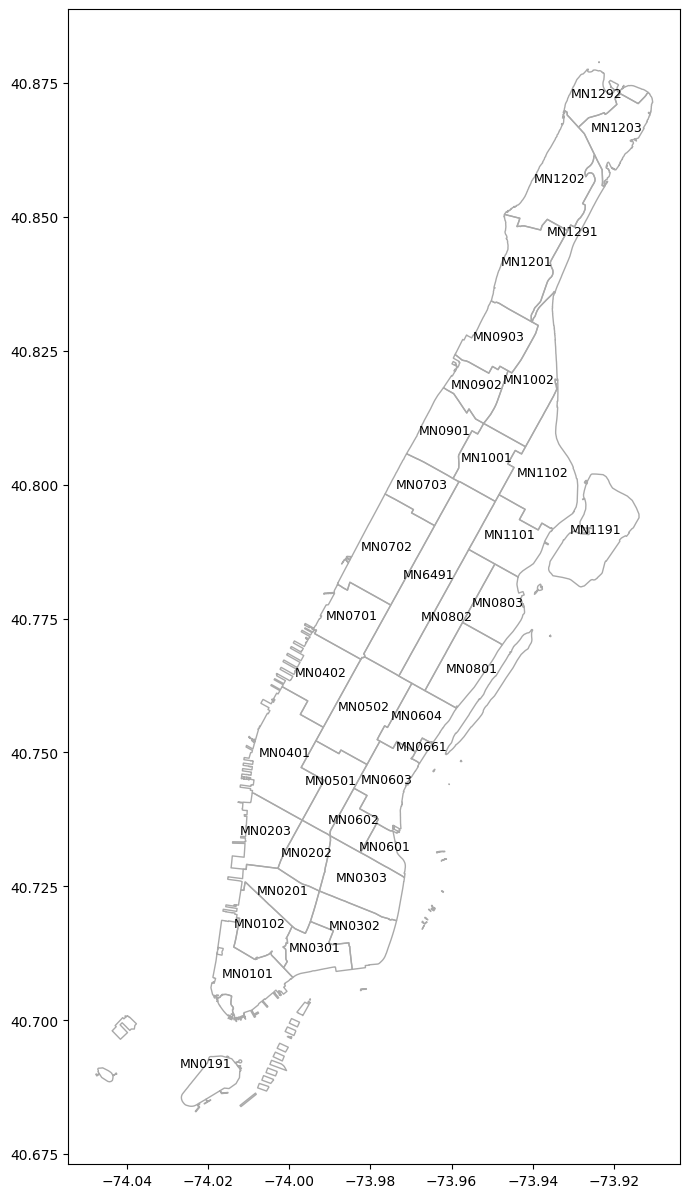

In [15]:
# Plot of NTA's in Manhattan

ax = sociodem_nta.plot(figsize = (20,15), color = 'none', edgecolor = 'darkgrey', zorder = 3)
sociodem_nta.apply(lambda x: ax.annotate(text = x['GeoID'], xy = x.geometry.centroid.coords[0], ha = 'center', fontsize = 9), axis = 1);
plt.show()

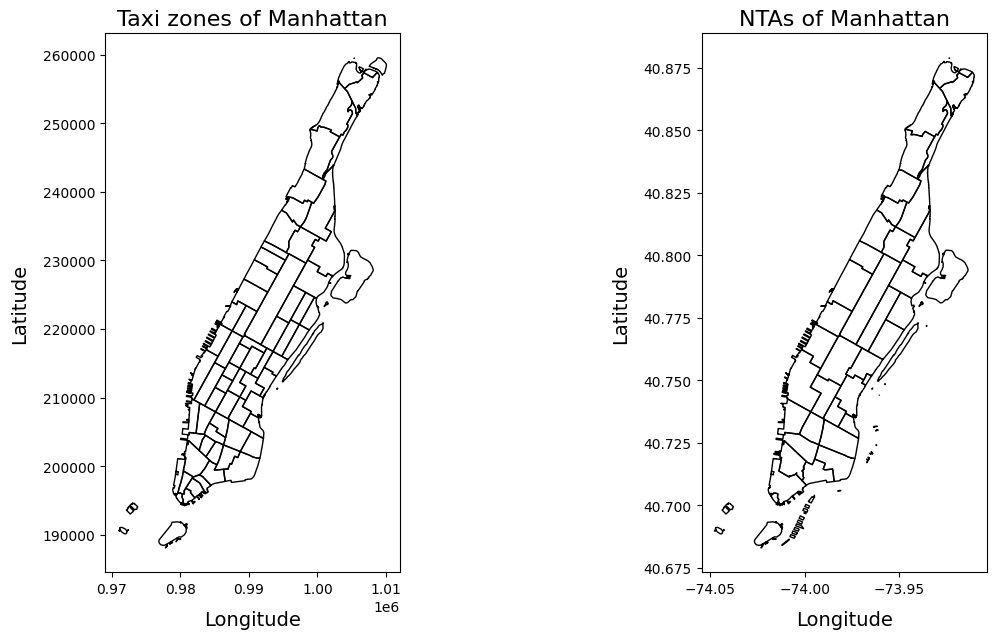

In [17]:
# Read geographic information on the taxi zones of NYC
taxi_zones = gpd.read_file("gs://taxi_data_outl/taxi_zones/taxi_zones.dbf")

# Recall the taxi zones and limit the geopandas dataframe of taxi zones to only Manhattan
taxi_zones_manhattan = taxi_zones[taxi_zones['borough'] == 'Manhattan']
taxi_zones_manhattan.head()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))

taxi_zones_manhattan.plot(ax=ax1, color='none', edgecolor='black', zorder=3)
ax1.set_xlabel('Longitude', fontsize = 14, labelpad = 10)
ax1.set_ylabel('Latitude', fontsize = 14, labelpad = 10)
ax1.set_title('Taxi zones of Manhattan', fontsize = 16)

nta_man.plot(ax=ax2, color='none', edgecolor='black', zorder=3)
ax2.set_xlabel('Longitude', fontsize = 14, labelpad = 10)
ax2.set_ylabel('Latitude', fontsize = 14, labelpad = 10)
ax2.set_title('NTAs of Manhattan', fontsize = 16)

plt.show()

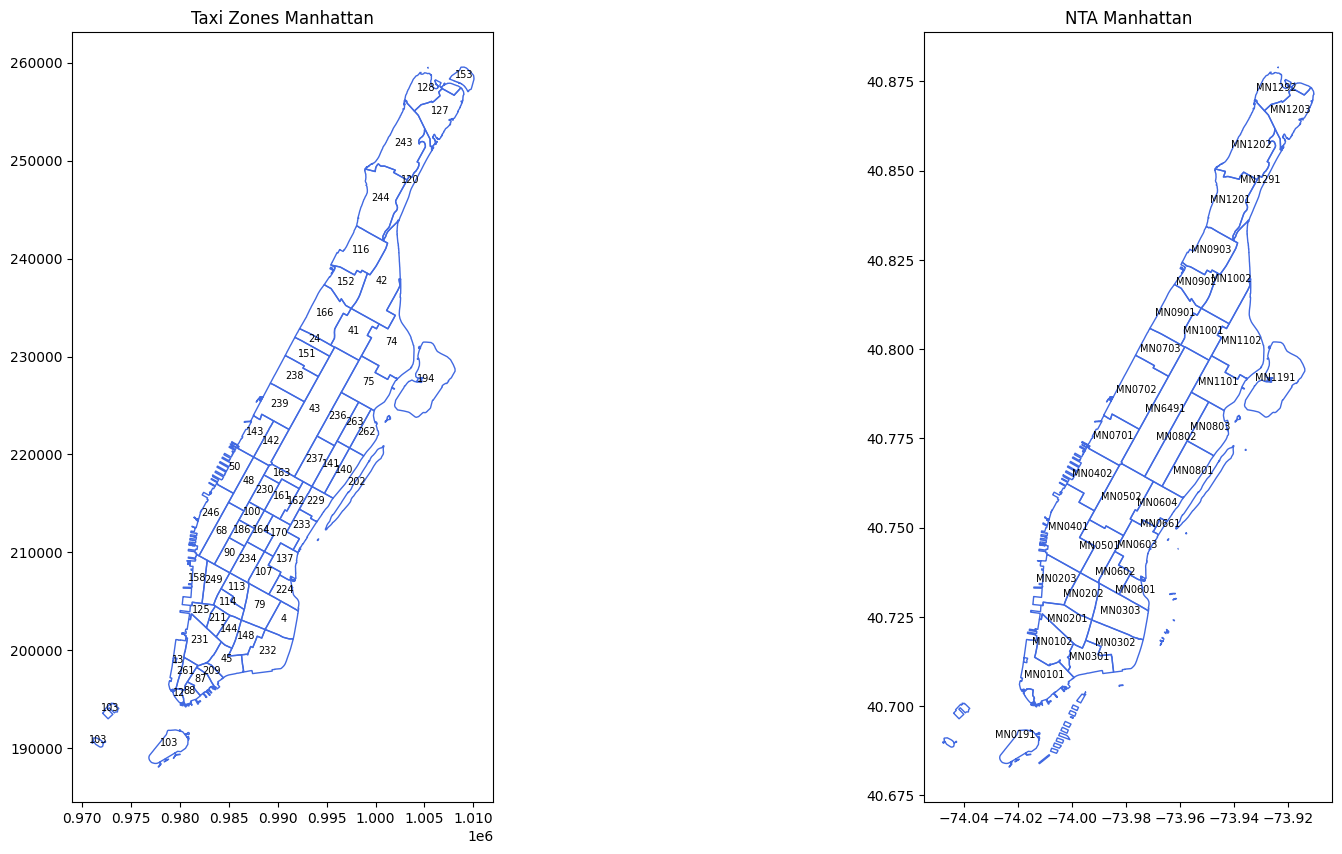

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

taxi_zones_manhattan.plot(ax=ax1, color='none', edgecolor='royalblue', zorder=3)
taxi_zones_manhattan.apply(lambda x, ax: ax.annotate(text = x['LocationID'], xy = x.geometry.centroid.coords[0], ha = 'center', fontsize = 7), ax = ax1, axis = 1);
ax1.set_title('Taxi Zones Manhattan')

sociodem_nta.plot(ax=ax2, color='none', edgecolor='royalblue', zorder=3)
sociodem_nta.apply(lambda x, ax: ax.annotate(text = x['GeoID'], xy = x.geometry.centroid.coords[0], ha = 'center', fontsize = 7), ax = ax2, axis = 1);
ax2.set_title('NTA Manhattan')

plt.show()

### Land use data

Extensive land-use and geographic data at the tax lot level is provided by NYC OpenData with the [Primary Land Use Tax Lot Output (PLUTO)](https://www.nyc.gov/site/planning/data-maps/open-data/dwn-pluto-mappluto.page).
The land use attribute is selected as relevant category and provides the following information:
<ul>
    <li> 01 One and Two Family Buildings</li>
    <li> 02 Multi-Family Walk-Up Buildings</li>
    <li> 03 Multi-Family Elevator Buildings</li>
    <li> 04 Mixed Residential and Commercial Buildings</li>
    <li> 05 Commercial and Office Buildings</li>
    <li> 06 Industrial and Manufacturing</li>
    <li> 07 Transportation and Utility</li>
    <li> 08 Public Facilities and Institutions</li>
    <li> 09 Open Space and Outdoor Recreation</li>
    <li> 10 Parking Facilities</li>
    <li> 11 Vacant Land</li>
</ul>

In [46]:
# Read the data
pluto = pd.read_csv("gs://taxi_data_outl/PLUTO/pluto_22v3_1.csv", usecols = ['borough', 'bct2020', 'landuse'])

# Only land-use data of Manhattan is of relevance 
pluto_manh = pluto[pluto['borough'] == 'MN']

# Remove missing values 
pluto_manh_na = pluto_manh.dropna()

In [30]:
# One-hot encoded version of the 'landuse' column
# This is an important step for the subsequent merge with the census block nta dataframe. Each row represents one observation.
# If a join is performed duplicated values could be lost.
one_hot = pd.get_dummies(pluto_manh_na['landuse'], prefix = 'landuse')

# Add the new columns to the original dataframe
pluto_one_hot = pd.concat([pluto_manh_na, one_hot], axis = 1)

In [31]:
# bct2020 is a float when it should be an integer
# Convert column from float to int
pluto_one_hot ['bct2020'] = pluto_one_hot['bct2020'].astype(int)

(42300, 14)

### Census block and NTA relationship

To successfully merge the sociodemographic data and land-use variables, another dataframe is required. The PLUTO dataset collects information at the tax lot level and provides additional details on the Borough Census Tract. The [2020 Census Tracts to 2020 NTAs Equivalency](https://www.opendatanetwork.com/dataset/data.cityofnewyork.us/hm78-6dwm) is a dataframe which shows the relationship of NTAs and census tracts and is required for the susbequent merge.

In [32]:
# Read data
census_nta = pd.read_excel("gs://taxi_data_outl/pre-processed/nyc_2020_census_tract_nta_cdta_relationships.xlsx", usecols = ["BoroCT2020", "BoroName", "NTACode"])

# Keep only information of Manhattan 
census_nta_man = census_nta[census_nta['BoroName'] == 'Manhattan']
census_nta_man = census_nta_man[census_nta_man['NTACode'] != 'BX0802']

# Drop BoroName
census_nta_man.drop('BoroName', axis = 1, inplace = True)

# Rename columns used for the join 
census_nta_man = census_nta_man.rename(columns = {'BoroCT2020':'bct2020'})

# Left join 
pluto_nta = pluto_one_hot.merge(census_nta_man, how = 'left', on = 'bct2020')

# Remove rows with missing values in the column 'NTACode'
pluto_nta.dropna(subset = ['NTACode'], inplace = True)

pluto_nta_grouped = pluto_nta.groupby('NTACode', as_index = False).sum()

# Drop columns that are not relevant anymore
pluto_nta_final = pluto_nta_grouped.drop(['bct2020', 'landuse'], axis = 1)

### Manual join of explanatory features and taxi trip record data


All the explanatory features have been loaded, pre-processed, and merged into a final dataframe. The next step is to combine this dataframe with the taxi trip record data. However, due to disparities between the NTA's (Neighborhood Tabulation Areas) and taxi zones, a standard attribute join was not applicable. Instead, an attempt was made to establish a spatial connection using the geometry information. Various spatial join methods such as intersect(), within(), and s_join_nearest() were employed, but none of them successfully merged the locations accurately. The difficulties arose from nested areas, partial overlaps, and non-intersecting regions. As a result, the geographic areas of NTA's were manually edited to match the taxi zone areas.

In [47]:
# Read the dataset
external_features = pd.read_excel("gs://taxi_data_outl/feature_external_v6.xlsx")

# Drop irrelevant columns
external_features.drop('NTACode', axis = 1, inplace = True)

In [48]:
# Calculate the median of each column
median_values_external_features = external_features.median()

# Replace NaN values with median values
external_features.fillna(median_values_external_features, inplace=True)

In [56]:
# Merge external dataframe with pre-processed and transformed taxi trip record data (including weather data)
manhattan_time_weather_ext =  manhattan_time_weather.merge(external_features, how = 'left', left_on = 'PULocationID', right_on = 'LocationID')

# Drop irrelevant columns 
manhattan_final = manhattan_time_weather_ext.drop(['LocationID','zone', 'borough', 'geometry', 'OBJECTID', 'nta2020'], axis = 1)

In [39]:
# Export the final dataframe

manhattan_final.to_csv('gs://final_prep_data/manhattan_spatiotemporal.csv', index=False)

## Correlation analysis of predictor variables

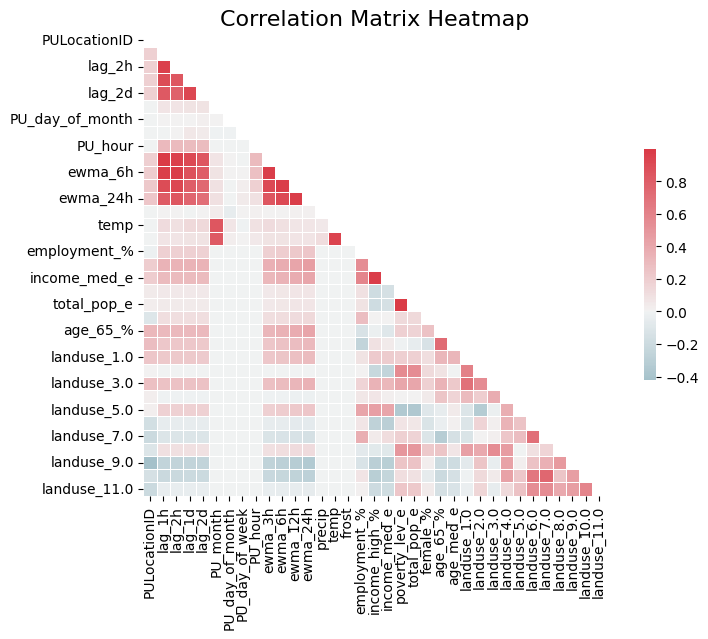

In [57]:
# Visualization of the correlation matrix using heatmap

corr_matrix = manhattan_final.corr()
corr_matrix_excluding_target = corr_matrix.drop('PU_count', axis=0).drop('PU_count', axis=1)
mask = np.triu(np.ones_like(corr_matrix_excluding_target, dtype=bool))

fig, ax = plt.subplots(figsize=(10, 6))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr_matrix_excluding_target, mask=mask, cmap=cmap, annot=False, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.title('Correlation Matrix Heatmap', fontsize=16)
# plt.savefig('multicoll_temporal.png')
plt.show()

In [58]:
# Get all feature pairs with correlation greater than 0.7

high_corr_pairs = [(corr_matrix_excluding_target.columns[i], corr_matrix_excluding_target.columns[j]) for i in range(len(corr_matrix_excluding_target.columns))
                  for j in range(i+1, len(corr_matrix_excluding_target.columns)) if abs(corr_matrix_excluding_target.iloc[i,j]) > 0.7]
for pair in high_corr_pairs:
    print(f"{pair[0]} and {pair[1]} have an autocorrelation > 0.7")

lag_1h and lag_2h have an autocorrelation > 0.7
lag_1h and lag_1d have an autocorrelation > 0.7
lag_1h and lag_2d have an autocorrelation > 0.7
lag_1h and ewma_3h have an autocorrelation > 0.7
lag_1h and ewma_6h have an autocorrelation > 0.7
lag_1h and ewma_12h have an autocorrelation > 0.7
lag_1h and ewma_24h have an autocorrelation > 0.7
lag_2h and lag_1d have an autocorrelation > 0.7
lag_2h and lag_2d have an autocorrelation > 0.7
lag_2h and ewma_3h have an autocorrelation > 0.7
lag_2h and ewma_6h have an autocorrelation > 0.7
lag_2h and ewma_12h have an autocorrelation > 0.7
lag_2h and ewma_24h have an autocorrelation > 0.7
lag_1d and lag_2d have an autocorrelation > 0.7
lag_1d and ewma_3h have an autocorrelation > 0.7
lag_1d and ewma_6h have an autocorrelation > 0.7
lag_1d and ewma_12h have an autocorrelation > 0.7
lag_1d and ewma_24h have an autocorrelation > 0.7
lag_2d and ewma_3h have an autocorrelation > 0.7
lag_2d and ewma_6h have an autocorrelation > 0.7
lag_2d and ewma_12h 